In [13]:
using Revise
using MajoranaPropagation
using PauliPropagation

using Plots 
using LaTeXStrings
using TimerOutputs

Simulate the dynamics of the spinful Hubbard model on a 1D chain of $N$ spinful sites. The Hamiltonian is
$$\hat{H}=-t \sum_{i, \sigma=\{\uparrow, \downarrow\}}\left(\hat{c}_{i, \sigma}^{\dagger} \hat{c}_{i+1, \sigma}+\hat{c}_{i+1, \sigma}^{\dagger} \hat{c}_{i, \sigma}\right)+U \sum_i \hat{n}_{i \uparrow} \hat{n}_{i \downarrow}$$

In [14]:
N_spinful_sites = 20
t = 1.
U = 1.5

n_layers = 4
dt = 0.07

0.07

Get 1D connectivity, and create the circtuit for implementing a single layer of first order Trotterization.

In [15]:
topo = bricklayertopology(N_spinful_sites)
circ_single, thetas_single = hubbard_circ_fermionic_sites(topo, N_spinful_sites, 1, t, U, dt);

#### Set the truncations
1. `min_abs_coeff`: PP coefficient truncation
2. `W`: weight truncation (aka monomial truncation)
3. `max_singles`: number of unpaired Majoranas, namely the number of indices $i$ where only one of $\gamma_i$, $\gamma'_i$ are non-zero
4. `max_sins`: PP truncation for dynamics

In [16]:
min_abs_coeff = 1.e-8
W = Inf
max_singles = 10

max_single_filter = create_max_single_filter(2 * N_spinful_sites)
custom_trunc = let max_single_filter=max_single_filter, max_singles = max_singles
    (mstr, coeff) -> (compute_max_single(mstr, 0, max_single_filter) > max_singles)
end

#15 (generic function with 1 method)

Set the inital state as the checkerboard state $\ket{\uparrow\downarrow\cdots\uparrow\downarrow}$

In [17]:
#initial state 
initial_state_label = "Checkerboard"

create_up_part_at = []
create_down_part_at = []

for j=1:N_spinful_sites 
    if j % 2 == 1
        push!(create_up_part_at, j)
    else 
        push!(create_down_part_at, j)
    end 
end

mps_initial_state = []
for uppart in create_up_part_at
    push!(mps_initial_state, 2*uppart -1)
end 
for downpart in create_down_part_at
    push!(mps_initial_state, 2*downpart)
end

Backpropagate $n_{2,\uparrow}$, the up density on site 2

In [18]:
to = TimerOutput()

site_index = 3
obs = spinfulmajoranasum(N_spinful_sites, :nu, site_index)

@show obs 

res = zeros(n_layers+1)
res[1] = overlap_with_fock_spinful(obs, create_up_part_at, create_down_part_at, 2 * N_spinful_sites)

for k=1:n_layers
    @timeit to "propagate" propagate!(circ_single, obs, thetas_single, min_abs_coeff=min_abs_coeff, max_weight=W, customtruncfunc=custom_trunc)
    @timeit to "evaluate" res[k+1] = overlap_with_fock_spinful(obs, create_up_part_at, create_down_part_at, 2 * N_spinful_sites)
end 

to

obs = MajoranaSum with 2 term(s):(
    0.5 * 00000000000000000000000000000000000000000000000000000000000000000000000000000000
    0.5 * 00000000110000000000000000000000000000000000000000000000000000000000000000000000)


──────────────────────────────────────────────────────────────────────
                             Time                    Allocations      
                    ───────────────────────   ────────────────────────
 Tot / % measured:       210ms /  32.8%           69.9MiB /  14.0%    

Section     ncalls     time    %tot     avg     alloc    %tot      avg
──────────────────────────────────────────────────────────────────────
propagate        4   68.3ms   99.2%  17.1ms   8.72MiB   88.9%  2.18MiB
evaluate         4    534μs    0.8%   134μs   1.09MiB   11.1%   280KiB
──────────────────────────────────────────────────────────────────────

If desired, you can benchmark the MP results with an ITensor implementation of the same circuits used in `propagate!`.

In [19]:
do_mps = false

if do_mps
    _, _, mps_circ_single, mps_thetas_single = hubbard_circ_fermionic_sites(topo, N_spinful_sites, 1, t, U, dt; return_mps_instructions=true);
    include("mps_codes.jl")
    mps_obs = "N"
    #index for an "up" density
    mps_index = 2*site_index-1
    χ = 100

    res_mps = zeros(n_layers+1)
    res_mps[1] = run_circ_mps(2*N_spinful_sites, [], mps_initial_state, [], mps_obs; χ=χ)[mps_index]

    for k=1:n_layers
        mps_circ = repeat(mps_circ_single, k)
        mps_thetas = repeat(mps_thetas_single, k)
        res_mps[k+1] = run_circ_mps(2*N_spinful_sites, mps_circ, mps_initial_state, mps_thetas, mps_obs; χ=χ)[mps_index]
    end 
    println("Difference with MP: ", res .- res_mps)
end

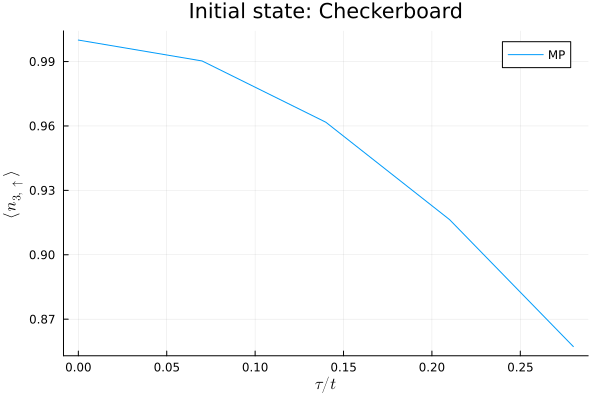

In [20]:
p = plot(dt*(0:n_layers)./ t, res, label="MP", xlabel=L"\tau/t", ylabel=L"\langle n_{%$site_index,\uparrow}\rangle", title = "Initial state: " * initial_state_label)
if do_mps
    plot!(p, dt*(0:n_layers) ./ t, res_mps, label="mps", color=:black, linestyle=:dash)
end 
display(p)